In [107]:
import pandas as pd
import pypsa

In [108]:
# Load PyPSA network.
n = pypsa.Network("./base_s_90_elec_lc1.0_Co2L0.01.nc")

INFO:pypsa.io:Imported network base_s_90_elec_lc1.0_Co2L0.01.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


{'nodes': {'Bus': <matplotlib.collections.PatchCollection at 0x192a69545c0>},
 'branches': {'Link': <matplotlib.collections.LineCollection at 0x192a54b7bc0>,
  'Line': <matplotlib.collections.LineCollection at 0x192a33deab0>},
 'flows': {}}

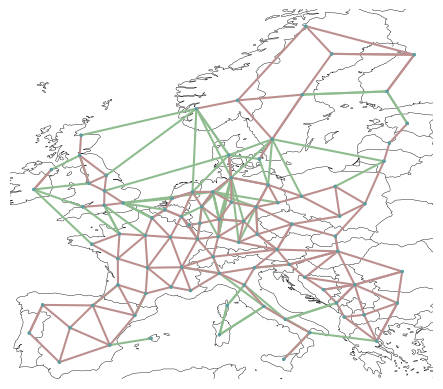

In [109]:
# Map overview of the network (for reference).
n.plot.map()

In [110]:
# Overview of the networks: buses correspond to nodes, this is a network with 90 nodes across all of Europe.
n.buses[n.buses.carrier == "AC"] # all nodes.

,v_nom,type,x,y,carrier,unit,location,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network,substation_lv,substation_off,country
Bus,,,,,,,,,,,,,,,,
AL0 0,380.0,,19.845910,41.511340,AC,,,1.0,0.0,inf,PQ,,,1.0,1.0,AL
AT0 0,380.0,,13.874983,47.488807,AC,,,1.0,0.0,inf,Slack,AT0 0 CCGT,,1.0,1.0,AT
BA0 0,380.0,,18.001468,43.935339,AC,,,1.0,0.0,inf,PQ,,,1.0,1.0,BA
BE0 0,380.0,,5.386936,50.419036,AC,,,1.0,0.0,inf,PQ,,,1.0,1.0,BE
BE0 1,380.0,,3.923387,51.020553,AC,,,1.0,0.0,inf,PQ,,,1.0,1.0,BE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE1 0,380.0,,13.450366,57.284545,AC,,,1.0,0.0,inf,PQ,,,1.0,1.0,SE
SE1 1,380.0,,16.132706,61.241326,AC,,,1.0,0.0,inf,PQ,,,1.0,1.0,SE
SE1 2,380.0,,18.731434,64.858085,AC,,,1.0,0.0,inf,PQ,,,1.0,1.0,SE


In [111]:
# Save all nodes with coordinates.
n.buses[n.buses.carrier == "AC"][["x", "y"]].to_csv("./nodes.csv")

In [112]:
# Prepare cost dataframe.
costs = pd.DataFrame(columns = ["capital_cost", "unit"])

In [113]:
# Save all lines including capacities (s_nom), both nodes (bus0, bus1), and the line length and capital cost.
n.lines[n.lines.carrier == "AC"][["s_nom", "bus0", "bus1", "length", "capital_cost"]].to_csv("./lines.csv")
# Compute capital cost per MWkm.
costs.loc["AC_line", "capital_cost"] = n.lines.loc["0", "capital_cost"] / n.lines.loc["0", "length"]
costs.loc["AC_line", "unit"] = "EUR/MWkm"

# Save all links including capacities (p_nom), both nodes (bus0, bus1), and the capital cost.
n.links[n.links.carrier == "DC"][["p_nom", "bus0", "bus1", "length", "capital_cost"]].to_csv("./links.csv")
# Compute capital cost per MW.
costs.loc["DC_link", "capital_cost"] = n.links.loc["relation/5487095", "capital_cost"] / n.links.loc["relation/5487095", "length"]
costs.loc["DC_link", "unit"] = "EUR/MWkm"


In [114]:
# Save all capacity factors (hourly) for solar and wind generators.
fixsolar_generators = n.generators[n.generators.carrier.str.contains("solar$", regex=True)].index
satsolar_generators = n.generators[n.generators.carrier.str.contains("hsat")].index
onwind_generators = n.generators[n.generators.carrier.str.contains("onwind")].index
offwind_generators = n.generators[n.generators.carrier.str.contains("offwind")].index
ror_generators = n.generators[n.generators.carrier == ("ror")].index

# Solar fixed tilt CF.
fixsolar_cf = n.generators_t.p_max_pu.loc[:, fixsolar_generators].round(3)
fixsolar_cf.to_csv("./fixsolar_cf.csv")
costs.loc["fixsolar", "capital_cost"] = n.generators.loc[fixsolar_generators, "capital_cost"].iloc[0]
costs.loc["fixsolar", "unit"] = "EUR/MW"

# Solar single axis tracking CF.
satsolar_cf = n.generators_t.p_max_pu.loc[:, satsolar_generators].round(3)
satsolar_cf.to_csv("./satsolar_cf.csv")
costs.loc["satsolar", "capital_cost"] = n.generators.loc[satsolar_generators, "capital_cost"].iloc[0]
costs.loc["satsolar", "unit"] = "EUR/MW"

# Onshore Wind CF.
onwind_cf = n.generators_t.p_max_pu.loc[:, onwind_generators].round(3)
onwind_cf.to_csv("./onwind_cf.csv")
costs.loc["onwind", "capital_cost"] = n.generators.loc["SK0 0 onwind", "capital_cost"]
costs.loc["onwind", "unit"] = "EUR/MW"

# Onshore Wind CF.
offwind_cf = n.generators_t.p_max_pu.loc[:, offwind_generators].round(3)
offwind_cf.to_csv("./offwind_cf.csv")
# Capital costs for onshore wind are dependent on the node, so saved separately.
offwind_costs = n.generators[n.generators.carrier.str.contains("offwind")]["capital_cost"].round(0)
offwind_costs.to_csv('./offwind_costs.csv')

# ROR CF.
ror_cf = n.generators_t.p_max_pu.loc[:, ror_generators].round(3)
ror_cf.to_csv("./ror_cf.csv")
n.generators.loc[ror_generators, ["bus", "p_nom", "capital_cost"]].to_csv("./ror_plants.csv")
costs.loc["ror", "capital_cost"] = n.generators.loc[n.generators.carrier =="ror", "capital_cost"].iloc[0]
costs.loc["ror", "unit"] = "EUR/MW"


In [115]:
# Save load per node.
n.loads_t.p_set.round(0).to_csv("./load.csv")

In [116]:
# Save hydropower plants
n.storage_units[n.storage_units.carrier == "PHS"][["bus", "p_nom", "capital_cost", "max_hours", "efficiency_dispatch"]].to_csv("./phs_plants.csv")
costs.loc["PHS", "capital_cost"] = n.storage_units.loc[n.storage_units.carrier =="PHS", "capital_cost"].iloc[0]
costs.loc["PHS", "unit"] = "EUR/MW"

n.storage_units[n.storage_units.carrier == "hydro"][["bus", "p_nom", "capital_cost", "max_hours", "efficiency_dispatch"]].to_csv("./hydro_plants.csv")
costs.loc["hydro", "capital_cost"] = n.storage_units.loc[n.storage_units.carrier =="hydro", "capital_cost"].iloc[0]
costs.loc["hydro", "unit"] = "EUR/MW"

# Hydropower inflow. (hourly) (MWh)
n.storage_units_t.inflow.round(0).to_csv("./inflow.csv")

In [117]:
# Existing gas capacity, bus, marginal cost, capital cost (for OCGT and CCGT).
n.generators[n.generators.carrier.str.contains("GT")][["bus", "carrier", "p_nom", "marginal_cost", "capital_cost"]].to_csv("gas.csv")

costs.loc["OCGT", "capital_cost"] = n.generators.loc[n.generators.carrier == "OCGT", "capital_cost"].iloc[0]
costs.loc["OCGT", "unit"] = "EUR/MW"
costs.loc["CCGT", "capital_cost"] = n.generators.loc[n.generators.carrier == "CCGT", "capital_cost"].iloc[0]
costs.loc["CCGT", "unit"] = "EUR/MW"



In [118]:
costs.to_csv('./costs.csv')

In [119]:
# with pd.option_context('display.max_rows', None):
#     print(n.generators.loc[n.generators.carrier == "CCGT", 'marginal_cost'])
